**NOTE:**

Visualize active currents during rest and -50 pA

**UPDATE:**

Debug missing channel current variables. Added ina/ik/ica to RANGE section in mod files.

# Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

tick_major = 6
tick_minor = 4
plt.rcParams["xtick.major.size"] = tick_major
plt.rcParams["xtick.minor.size"] = tick_minor
plt.rcParams["ytick.major.size"] = tick_major
plt.rcParams["ytick.minor.size"] = tick_minor

font_small = 12
font_medium = 13
font_large = 14
plt.rc('font', size=font_small)          # controls default text sizes
plt.rc('axes', titlesize=font_medium)    # fontsize of the axes title
plt.rc('axes', labelsize=font_medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_small)    # legend fontsize
plt.rc('figure', titlesize=font_large)   # fontsize of the figure title

import matplotlib.colors as clr

# Model Controls

## Loading the Model

In [2]:
from neuron import h
h.load_file("runModel.hoc")

	1 
	1 
Setting temperature to 34.000000 C
Setting simulation time step to 0.100000 ms
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
**********************
cADpyr232_L5_TTPC1_0fb1ca4724[0].soma[0]
1 
1 
1 
	1 
	1 
	1 


1.0

## Initialize Model Params

In [3]:
def init_settings(nav12=1,
                  nav16=1,
                  dend_nav12=1, 
                  soma_nav12=1, 
                  ais_nav12=1, 
                  dend_nav16=1, 
                  soma_nav16=1,
                  ais_nav16=1, 
                  axon_Kp=1,
                  axon_Kt =1,
                  axon_K=1,
                  soma_K=1,
                  dend_K=1,
                  gpas_all=1,
                  hcn=1):
    
    # create default model parameters to avoid loading the model
    
    h.dend_na12 = 0.026145/2 
    h.dend_na16 = h.dend_na12 
    h.dend_k = 0.004226 * soma_K


    h.soma_na12 = 0.983955/10 
    h.soma_na16 = h.soma_na12 
    h.soma_K = 0.303472 * soma_K

    h.ais_na16 = 4 
    h.ais_na12 = 4 
    h.ais_ca = 0.000990
    h.ais_KCa = 0.007104

    h.node_na = 2

    h.axon_KP = 0.973538 * axon_Kp
    h.axon_KT = 0.089259 * axon_Kt
    h.axon_K = 1.021945 * axon_K

    h.cell.axon[0].gCa_LVAstbar_Ca_LVAst = 0.001376286159287454
    
    #h.soma_na12 = h.soma_na12/2
    h.naked_axon_na = h.soma_na16/5
    h.navshift = -10
    h.myelin_na = h.naked_axon_na
    h.myelin_K = 0.303472
    h.myelin_scale = 10
    h.gpas_all = 3e-5 * gpas_all
    h.cm_all = 1
    
    
    h.dend_na12 = h.dend_na12 * nav12 * dend_nav12
    h.soma_na12 = h.soma_na12 * nav12 * soma_nav12
    h.ais_na12 = h.ais_na12 * nav12 * ais_nav12
    
    h.dend_na16 = h.dend_na16 * nav16 * dend_nav16
    h.soma_na16 = h.soma_na16 * nav16 * soma_nav16
    h.ais_na16 = h.ais_na16 * nav16 * ais_nav16
    
    h.hcn = hcn
    
    h.working()

## Initialize Stimulation Params

In [4]:
def init_stim(sweep_len = 800, stim_start = 100, stim_dur = 500, amp = 0.5, dt = 0.01):
    # updates the stimulation params used by the model
    # time values are in ms
    # amp values are in nA
    
    h("st.del = " + str(stim_start))
    h("st.dur = " + str(stim_dur))
    h("st.amp = " + str(amp))
    h.tstop = sweep_len
    h.dt = dt

## Run the model

In [5]:
def run_model(start_Vm = -72):

    h.finitialize(start_Vm)
    timesteps = int(h.tstop/h.dt)
    
    Vm = np.zeros(timesteps)
    I = {}
    I['Na'] = np.zeros(timesteps)
    I['Ca'] = np.zeros(timesteps)
    I['K'] = np.zeros(timesteps)
    t = np.zeros(timesteps)
    
    for i in range(timesteps):
        Vm[i] = h.cell.soma[0].v
        I['Na'][i] = h.cell.soma[0](0.5).ina
        I['Ca'][i] = h.cell.soma[0](0.5).ica
        I['K'][i] = h.cell.soma[0](0.5).ik
        t[i] = i*h.dt / 1000
        h.fadvance()
        
    return Vm, I, t

## Display currents

print('NaTs2_t:', h.cell.soma[0].psection()['density_mechs']['NaTs2_t'])
print('na12:', h.cell.soma[0].psection()['density_mechs']['na12'])

print(dir(h.cell.axon[0](0.5).ica_Ca_HVA))
print(h.cell.axon[0](0.5).ica_Ca_HVA)
h.cell.axon[0].psection()['density_mechs'].keys()

In [6]:
def record_all_currents(sections,is_to_plot):
    timesteps = int(h.tstop/h.dt)
    
    all_is = {}
    for curr_sec in sections:
        all_is[curr_sec] = np.zeros([len(is_to_plot[curr_sec])+1,timesteps])
    volts = np.zeros([timesteps,1])
    h.finitialize(-80)
    for i in range(timesteps):
        for curr_sec in sections:
            curr_is = is_to_plot[curr_sec]
            curr_rec = all_is[curr_sec]
            for j in range(len(curr_is)):
                #print(f'j is {j} i is {i} curr_rec shape is {np.shape(curr_rec)}')
                #if (h.cell.soma[0].v<-10 and h.cell.soma[0].v>-50 ):
                h(f'val = cell.{curr_sec}[0].{curr_is[j]}(0.28)')
                #else:
                #    h.val = 0
                #tmp_str = f'soma_ref.{is_to_plot[j]}'
                #tmp_val = eval(tmp_str)
                curr_rec[j,i] = h.val
                #if (h.cell.soma[0].v<-10 and h.cell.soma[0].v>-50 ):
                h(f'val = cell.{curr_sec}[0].v(0.28)')
                #else:
                #    h.val = 0
            curr_rec[j+1,i] = h.val
            h.fadvance()
    return all_is
            
def display_all_currents(sections,is_to_plot,all_is,xlim):  
    timesteps = int(h.tstop/h.dt)
    times = np.cumsum(np.ones(timesteps)*h.dt)
    for curr_sec in sections:           
        curr_is = is_to_plot[curr_sec]
        curr_rec = all_is[curr_sec]
        fig,axs = plt.subplots(len(curr_is)+1,1,figsize=[10,30])
        for j in range(len(curr_is)):
            curr_ax = axs[j]
            curr_ax.plot(times,curr_rec[j,:])
            curr_ax.set_title(f'{curr_sec} {curr_is[j]}')
            curr_ax.set_xlim(xlim)
        curr_ax = axs[j+1]
        curr_ax.plot(times,curr_rec[j+1,:])
        curr_ax.set_title('volts')
        curr_ax.set_xlim(xlim)
def display_all_currents_overlaid(sections,is_to_plot,all_is,xlim): 
    timesteps = int(h.tstop/h.dt)
    times = np.cumsum(np.ones(timesteps)*h.dt)
    fig,axs = plt.subplots(len(sections),1,figsize=[10,30])
    for i,curr_sec in enumerate(sections):
        curr_ax = axs[i]
        curr_is = is_to_plot[curr_sec]
        curr_rec = all_is[curr_sec]
        for j in range(len(curr_is)):
            curr_ax.plot(times,curr_rec[j,:],label=curr_is[j])
        curr_ax.set_xlim(xlim)
        curr_ax.legend(loc='best')
        curr_ax.set_title(curr_sec)
        #curr_ax.plot(times,curr_rec[j+1,:],label='volts')
    #print(volts[2499])
    #print(np.min(volts))
    #axs[0,0].set_ylim([-80,50])
    #axs[1,0].plot(volts)
    #axs[1,0].set_ylim([-90,-60])

In [7]:
print(list(h.cell.soma[0].psection()['density_mechs'].keys()))
print(list(h.cell.axon[0].psection()['density_mechs'].keys()))
print(list(h.cell.apic[0].psection()['density_mechs'].keys()))
print(list(h.cell.dend[0].psection()['density_mechs'].keys()))

['pas', 'CaDynamics_E2', 'Ca_HVA', 'Ca_LVAst', 'Ih', 'NaTs2_t', 'SK_E2', 'SKv3_1', 'na12', 'na12mut', 'na16']
['pas', 'CaDynamics_E2', 'Ca_HVA', 'Ca_LVAst', 'K_Pst', 'K_Tst', 'NaTa_t', 'Nap_Et2', 'SK_E2', 'SKv3_1', 'na12', 'na12mut', 'na16']
['pas', 'Ih', 'Im', 'NaTs2_t', 'SKv3_1', 'na12', 'na12mut', 'na16']
['pas', 'Ih']


In [8]:
sections = ['soma','axon','apic', 'dend']
is_to_plot = {}

is_to_plot['soma'] = ['i_pas', 'i_cap', 'ica_Ca_HVA', 'ica_Ca_LVAst', 'ihcn_Ih', 'ina_NaTs2_t', 'ik_SK_E2', 'ik_SKv3_1', 'ina_na12', 'ina_na12mut', 'ina_na16']
is_to_plot['axon'] = ['i_pas', 'i_cap', 'ica_Ca_HVA', 'ica_Ca_LVAst', 'ik_K_Pst', 'ik_K_Tst', 'ina_NaTa_t', 'ina_Nap_Et2', 'ik_SK_E2', 'ik_SKv3_1', 'ina_na12', 'ina_na12mut', 'ina_na16']
is_to_plot['apic'] = ['i_pas', 'i_cap', 'ihcn_Ih', 'ik_Im', 'ina_NaTs2_t', 'ik_SKv3_1', 'ina_na12', 'ina_na12mut', 'ina_na16']
is_to_plot['dend'] = ['i_pas', 'i_cap', 'ihcn_Ih']

# -50 pA step

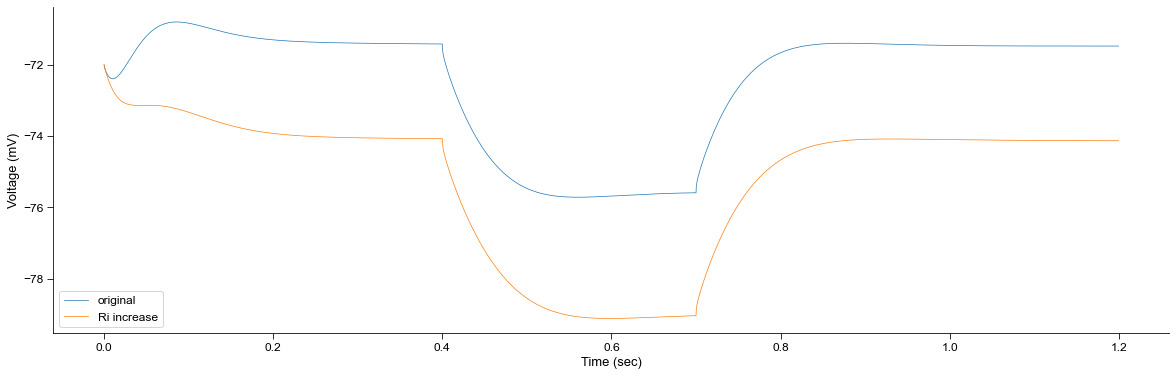

In [19]:
step_amp = -0.05
init_stim(stim_start=400, stim_dur=300, sweep_len=1200, dt=0.2, amp=step_amp)

init_settings()
Vm, I, t = run_model()
plt.figure(figsize=(20, 6))
plt.plot(t, Vm, lw=0.7, label='original')

init_settings(gpas_all=0, hcn=0.5)
Vm, I, t = run_model()
plt.plot(t, Vm, lw=0.7, label='Ri increase')

plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

original: 76.7289375831163
Ri increase: 96.19577505700988
diff: 19.466837473893577
% diff: 25.370920134018803


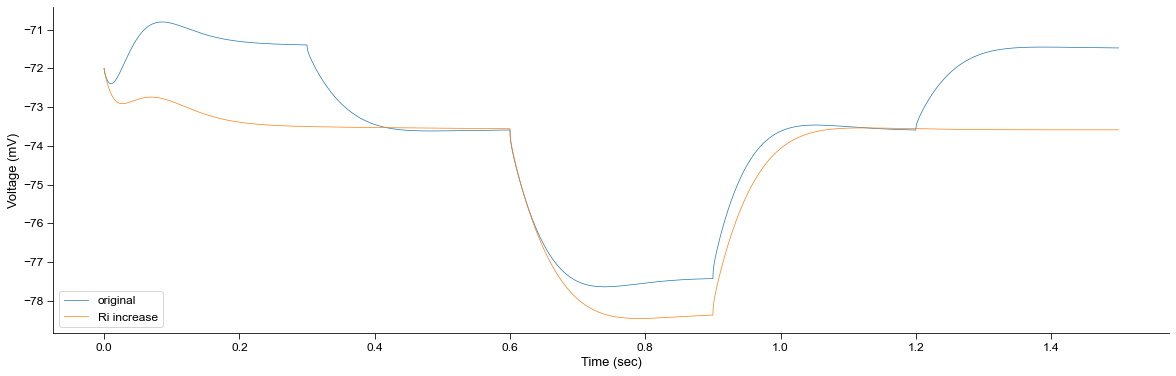

In [54]:
step_amp = -0.05
init_stim(stim_start=600, stim_dur=300, sweep_len=1500, dt=0.2, amp=step_amp)

iclamp = h.IClamp(h.cell.soma[0](0.5))
iclamp.delay = 300
iclamp.dur = 900
iclamp.amp = -0.025

init_settings()
Vm, I, t = run_model()
plt.figure(figsize=(20, 6))
plt.plot(t, Vm, lw=0.7, label='original')
start = int(0.6/0.2e-3)
end = int(0.9/0.2e-3)
original_ri = (Vm[end]-Vm[start])/-.05
print('original:', original_ri)

iclamp.amp = 0
init_settings(gpas_all=0, hcn=0.565)
Vm, I, t = run_model()
plt.plot(t, Vm, lw=0.7, label='Ri increase')
gpas0_ri = (Vm[end]-Vm[start])/step_amp
print('Ri increase:', gpas0_ri)
diff_ri = gpas0_ri-original_ri
print('diff:', diff_ri)
print('% diff:', diff_ri/original_ri*100)

plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

In [63]:
step_amp = -0.05
init_stim(stim_start=300, stim_dur=50, sweep_len=600, dt=0.2, amp=step_amp)

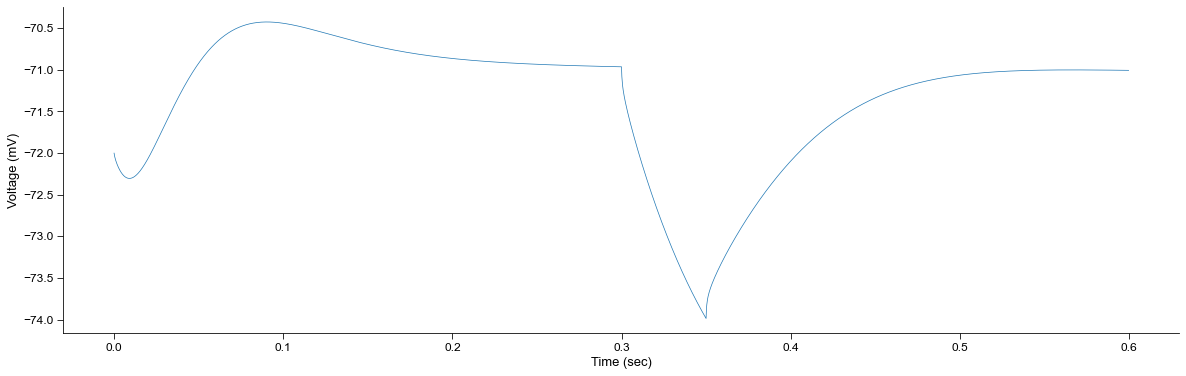

In [64]:
init_settings(gpas_all=0)
Vm, I, t = run_model()
plt.figure(figsize=(20, 6))
plt.plot(t, Vm, lw=0.7)
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.show()

In [37]:
all_is = record_all_currents(sections,is_to_plot)

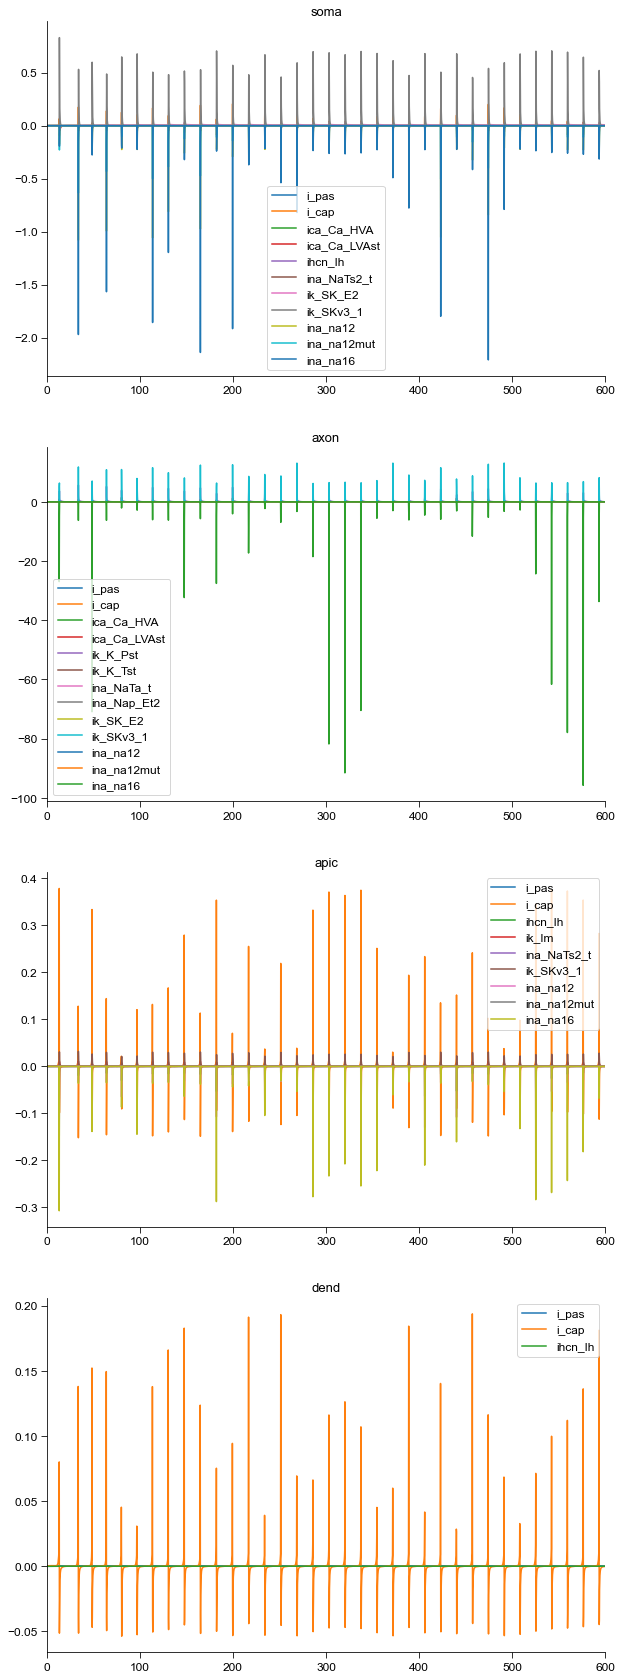

In [38]:
display_all_currents_overlaid(sections,is_to_plot,all_is,[0, 600]) # last argument is x axis limits

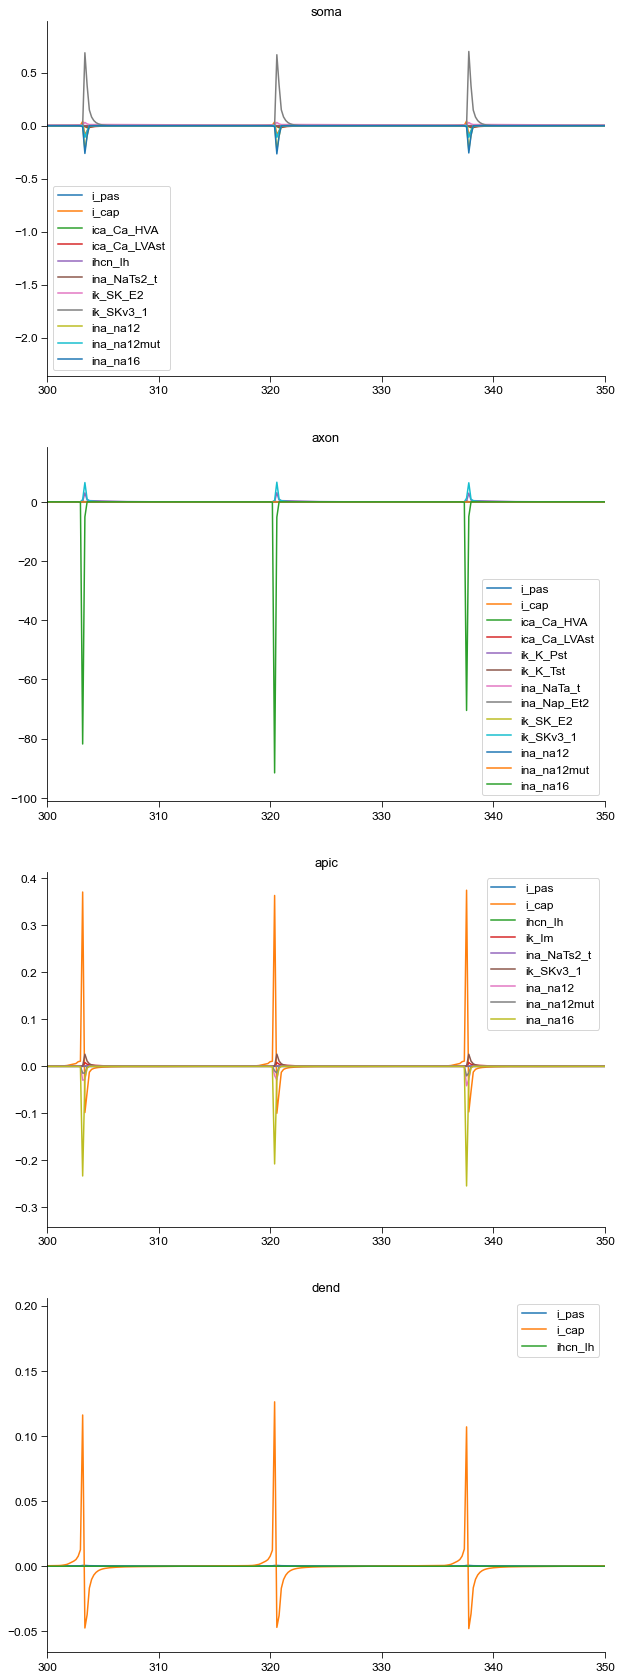

In [39]:
display_all_currents_overlaid(sections,is_to_plot,all_is,[300, 350]) # last argument is x axis limits

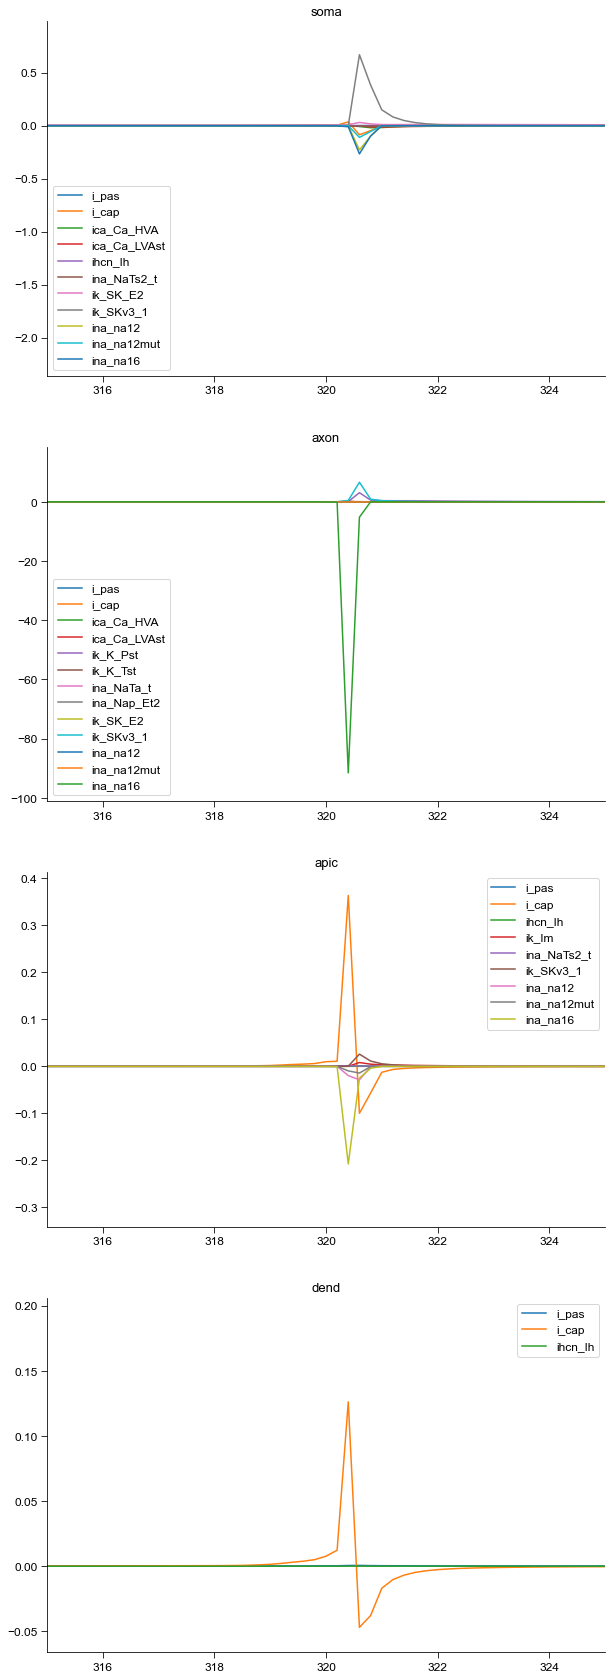

In [40]:
display_all_currents_overlaid(sections,is_to_plot,all_is,[315, 325]) # last argument is x axis limits

# 0 amp step

In [41]:
step_amp = 0
init_stim(stim_start=300, stim_dur=50, sweep_len=600, dt=0.2, amp=step_amp)

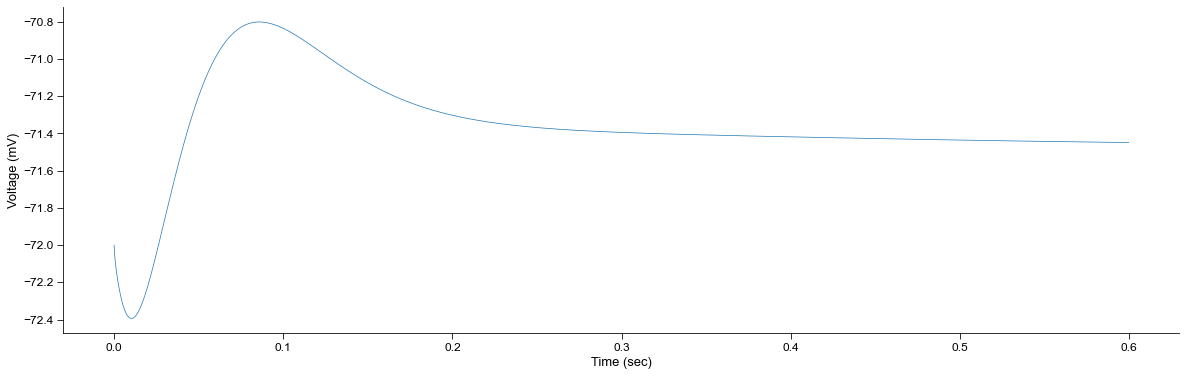

In [43]:
init_settings()
Vm, I, t = run_model()
plt.figure(figsize=(20, 6))
plt.plot(t, Vm, lw=0.7)
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.show()

In [42]:
all_is = record_all_currents(sections,is_to_plot)

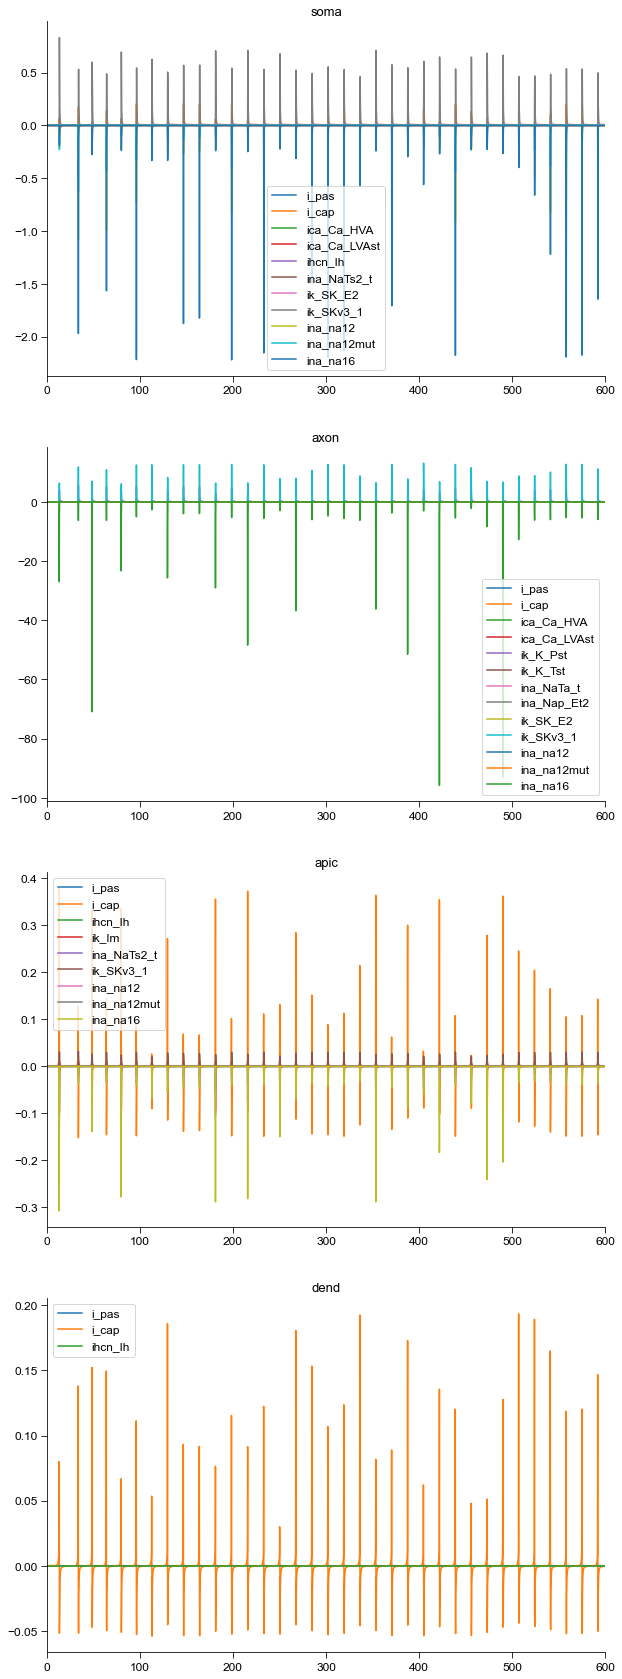

In [44]:
display_all_currents_overlaid(sections,is_to_plot,all_is,[0, 600]) # last argument is x axis limits

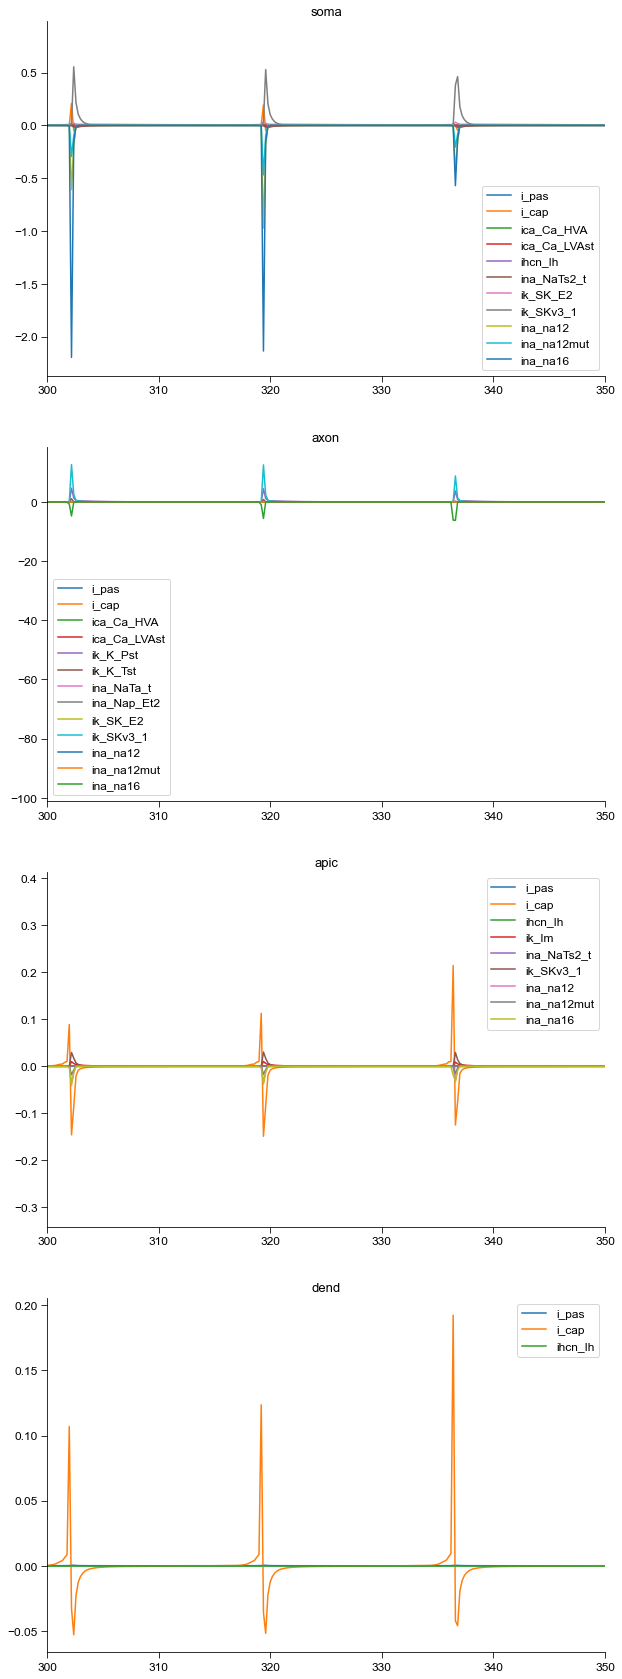

In [45]:
display_all_currents_overlaid(sections,is_to_plot,all_is,[300, 350]) # last argument is x axis limits

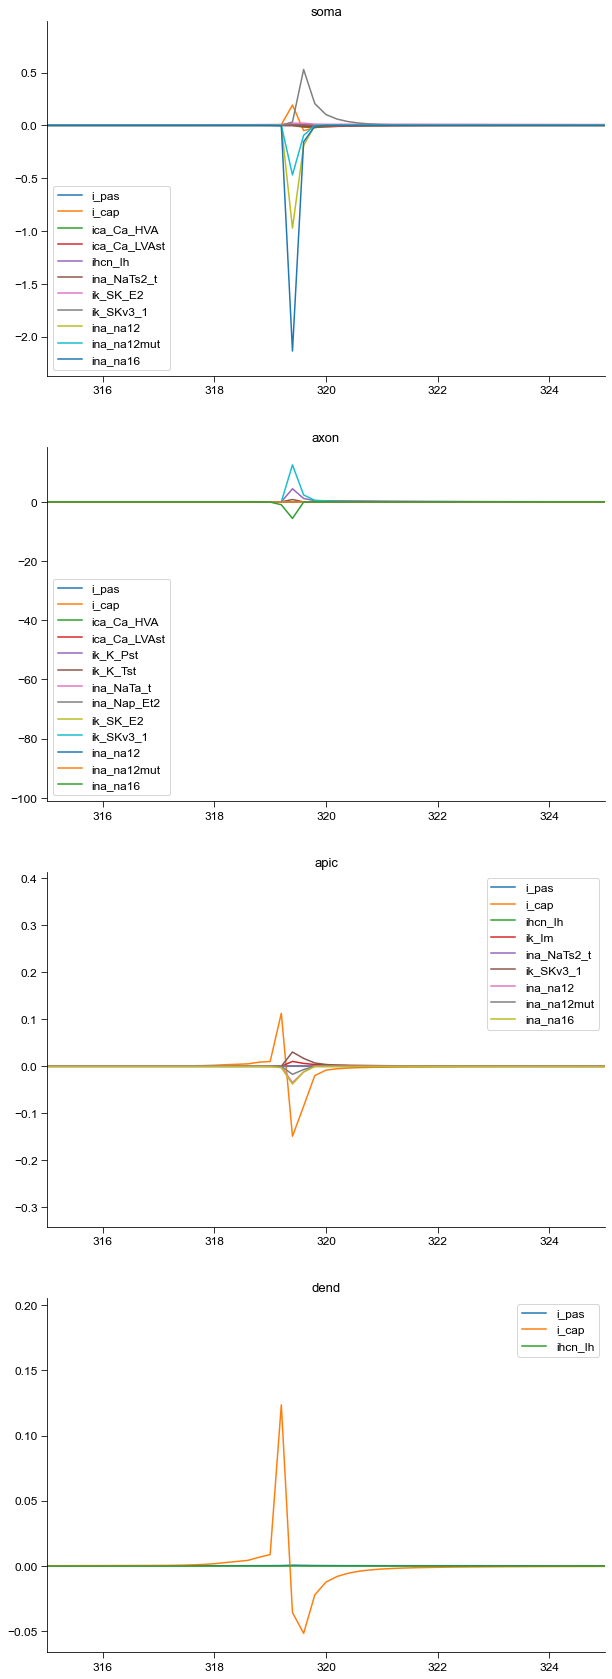

In [46]:
display_all_currents_overlaid(sections,is_to_plot,all_is,[315, 325]) # last argument is x axis limits